## This script clusters teams based on their route frequency.

I suspect that the NGS data we have only consists of games played on primetime (most likely NBC related games). So we cannot assume the data will be balanced for every team, as teams appear on primetime at varying frequencies. Therefore, we must somehow generalize teams who share tendencies (e.g. offensive philosophies like Air Coryell and West Coast) by clustering.

In [2]:
import math
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA



In [3]:
pd.set_option('display.max_columns', None)

In [143]:
# Initialize dictionaries of dataframes

data = {}
years = [18, 19, 20, 21, 22, 23]

pivots = []


In [144]:
# Load CSVs per year of 

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    data[x] = pd.read_csv('cleanData/refined/pbp_refined_20' + str(x) + '.csv')
# print(pbp[18].head())

# print(NGS_pbp[18].head())

print("done")


done


/var/folders/z2/rm0rvjws51g2b4p7_0ns_31w0000gp/T/ipykernel_94992/2147635500.py:5: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data[x] = pd.read_csv('cleanData/refined/pbp_refined_20' + str(x) + '.csv')


In [89]:
temp = data[18]

features = []

route_names = temp['route'].unique()
route_names.sort()

# features = ['route_names', ... ] 

seasons = [2018, 2019, 2020, 2021, 2022, 2023] * 32
seasons.sort()

print(route_names)

print(seasons)

['ANGLE' 'CORNER' 'CROSS' 'FLAT' 'GO' 'HITCH' 'IN' 'OUT' 'POST' 'SCREEN'
 'SLANT' 'WHEEL']
[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 20

In [159]:
for x in years:
    df = data[x]
    df = df[df['offense_personnel'] == '1 RB, 1 TE, 3 WR']
    df = df[df['qtr'] == 4]
    df = df[df['quarter_seconds_remaining'] <= 120]


    data[x] = df
    

# print(data[18])


### Create Pivot Tables 

In [145]:
for x in years:
    df = data[x]

    table = df.pivot_table(index='posteam', columns='route', aggfunc="size", fill_value=0)

    # Ignore formations for now since formations are nearly identical in all 2 min drills
    # table = pd.pivot_table(df, index='posteam', columns=['offense_formation', 'route'], aggfunc="sum", fill_value=0)
    # Combine into one list
    pivots.append(pd.concat([table.reset_index()], axis=1))


In [146]:
# Combine pivot tables into one pivot table with combined frequencies

# Should ignore_index be True?

# We want to do this vertically as we want to represent each team's seasonal data as a different entity
# This helps account for teams that have varying offenses between each season
combined_pivot = pd.concat(pivots, axis=0, ignore_index=True)

combined_pivot = combined_pivot.fillna(0)  # Or use another imputation strategy

# print(combined_pivot)

In [147]:

# Add season each row

combined_pivot.insert(0, 'season', seasons)    

print(combined_pivot)

route  season posteam  ANGLE  CORNER  CROSS  FLAT  GO  HITCH  IN  OUT  POST  \
0        2018     ARI      9      11     39    51  46     91  25   80    28   
1        2018     ATL     15      20     77    64  45     92  46   98    32   
2        2018     BAL     24       6     71    60  64     75  43   64    28   
3        2018     BUF     17      13     62    62  65     78  26   54    26   
4        2018     CAR     34       9     72    68  48     84  39   69    24   
..        ...     ...    ...     ...    ...   ...  ..    ...  ..  ...   ...   
187      2023     SEA      9       8     51    60  53     87  12   69    17   
188      2023      SF     36      10     56    43  30     43  80   84    42   
189      2023      TB     17      27     55    54  57     61  47   93    37   
190      2023     TEN     15      17     45    50  57     41  20   59    24   
191      2023     WAS     11      23     73    71  41     99  28   62    15   

route  SCREEN  SLANT  WHEEL  
0          59     22 

### Select features for clustering
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_pivot)


In [148]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [150]:
# Assign cluster labels
combined_pivot['Cluster'] = kmeans.labels_
print("\nClustering Results:")
print(combined_pivot[['Cluster']])

# Calculate Silhouette Score
score = silhouette_score(scaled_features, combined_pivot['Cluster'])
print(f"\nSilhouette Score: {score:.2f}")




Clustering Results:
route  Cluster
0            1
1            0
2            2
3            0
4            1
..         ...
187          1
188          0
189          0
190          1
191          1

[192 rows x 1 columns]

Silhouette Score: 0.18


In [76]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=route_names)

print(centroids)

      ANGLE    CORNER     CROSS      FLAT        GO     HITCH        IN  \
0 -0.451878 -0.180219 -0.300260 -0.561654 -0.426611 -0.551405 -0.320759   
1  0.470798  0.108041  0.312428  0.685239  0.461171  0.652370  0.288481   
2  0.587945  0.613170  0.392594  0.255449  0.475757  0.347524  0.634462   

        OUT      POST    SCREEN     SLANT     WHEEL  
0 -0.511635 -0.378212 -0.201646 -0.372319 -0.271182  
1  0.599724  0.410394  0.286764  0.443151 -0.303562  
2  0.349029  0.414453 -0.101841  0.222025  3.136812  


In [77]:
cluster_labels = kmeans.labels_
combined_pivot['Cluster'] = cluster_labels

# Calculate mean feature values per cluster
cluster_summary = combined_pivot.groupby('Cluster').mean()
print(cluster_summary)

# Now do it by frequency
cluster_sums = combined_pivot.groupby('Cluster').sum()
print(cluster_sums)


route       ANGLE    CORNER     CROSS      FLAT        GO     HITCH        IN  \
Cluster                                                                         
0        0.890000  0.820000  1.340000  1.780000  2.340000  2.700000  1.330000   
1        2.263158  1.157895  2.421053  4.881579  4.342105  5.947368  2.355263   
2        2.437500  1.750000  2.562500  3.812500  4.375000  5.125000  2.937500   

route         OUT      POST    SCREEN     SLANT   WHEEL  
Cluster                                                  
0        2.630000  1.340000  0.940000  1.100000  0.0100  
1        6.013158  2.618421  1.539474  2.592105  0.0000  
2        5.250000  2.625000  1.062500  2.187500  1.0625  
route    ANGLE  CORNER  CROSS  FLAT   GO  HITCH   IN  OUT  POST  SCREEN  \
Cluster                                                                   
0           89      82    134   178  234    270  133  263   134      94   
1          172      88    184   371  330    452  179  457   199     117   
2   

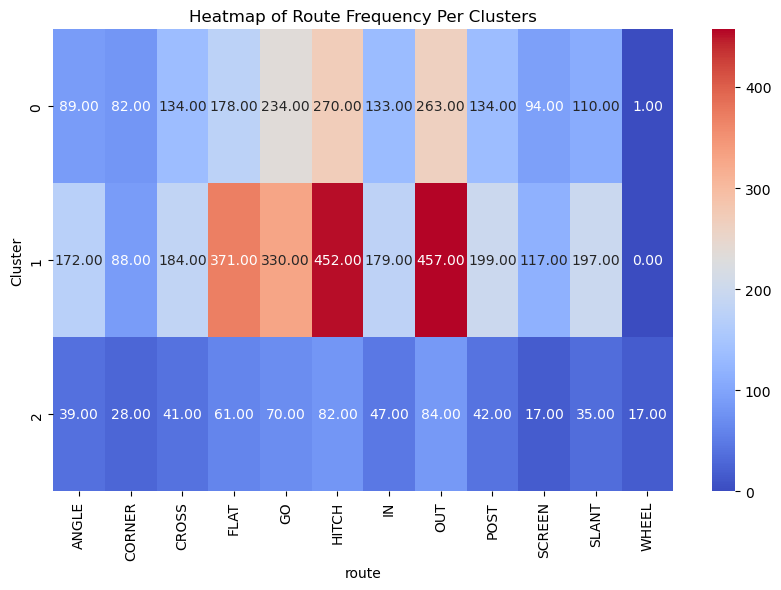

In [80]:
# Heatmap of route frequency raw numbers

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_sums, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Route Frequency Per Clusters")
plt.show()

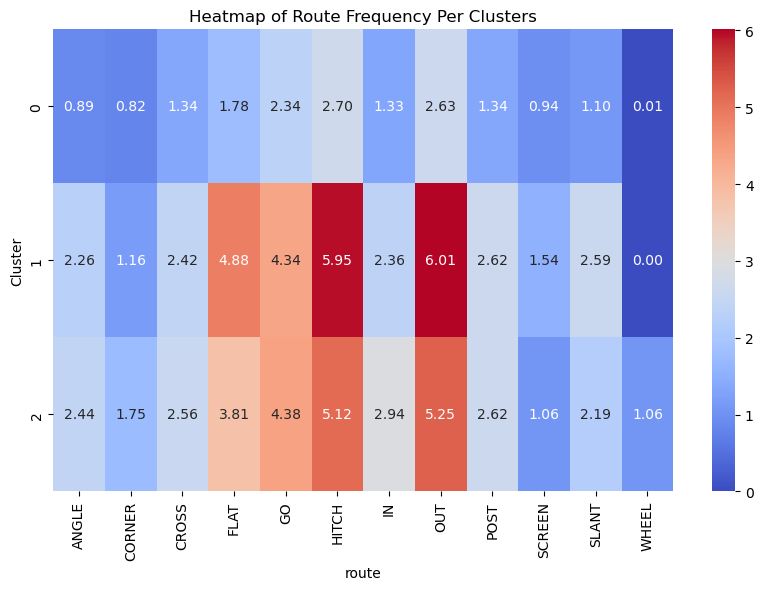

In [81]:
# Heatmap of route frequency average numbers

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Route Frequency Per Clusters")
plt.show()

In [84]:
# Cluster frequencies
print(combined_pivot['Cluster'].value_counts())

# Why are there so few teams in Cluster 2?

Cluster
0    100
1     76
2     16
Name: count, dtype: int64


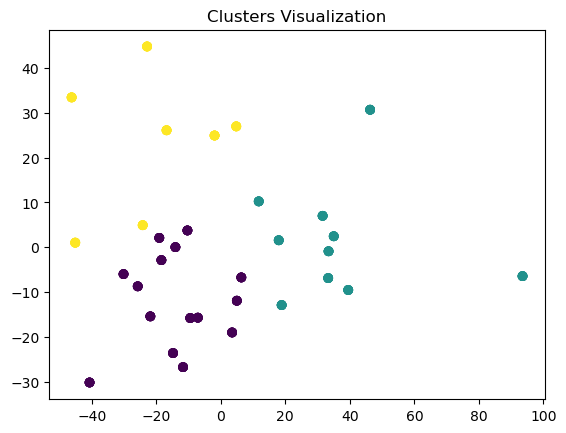

In [197]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_pivot)

# Scatter plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Clusters Visualization")
plt.show()

In [151]:
# TODO: Find way to add Cluster to each posteam per year

for x in years:
    df1 = data[x]

    result = pd.merge(df1, combined_pivot[['posteam', 'season', 'Cluster']], on = ['posteam', 'season'], how='left')

    data[x] = result

## Analysis

It appears teams that are **Cluster 0** tend to run short routes more frequently (e.g. flats, hitches, etc.) than others. However it also appears this cluster runs more routes more frequently in general, so it is possible that this model didn't account for teams who appear more frequently in the data (and consequently have greater frequency rates for every route). For instance, teams who have many primetime games like the Chiefs will have high frequency numbers in every route, while teams who rarely appear on SNF (e.g. Cleveland) will have little to no frequency. 

This means that teams who have identical offensive philosophies but different totals of routes run (e.g. 2022 Giants who had one game on SNF vs 2023 Giants who had two games) will be clustered differently despite the fact that they should (theorhetically) have similar route concept frequenices.

Additionally, this clustering may not necessarily be based on offensive philosophies. Rather, they could be based on team's situations and their need for aggression. For instance, teams who are down with only several seconds left must run *GO* and *OUT* routes more often than teams who have several timeouts and are down 2 or less points. More EDA needs to be conducted to see the full context of the plays. It appears **Cluster 0** has the greatest balance in route frequency, so it's possible this cluster contains plays made in less desperate situations for the offense.

Despite the above, this information is not necessarily valueless. We can assume that teams in **Cluster 0** are of higher quality than teams with lower route frequencies (such as **Cluster 1**). However, this is a weak correlation and there are better ways to cluster by quality than by route frequenices. *EPA* would likely be the best feature if we wanted to do that.

#### Takeaways
- One common tendency across all clusters is that routes such as hitches and outs are run frequently in two-minute drills. Hitches are typically easy completions while outs are useful to help stop the clock, so these would explain their high frequency rates.
  - Defenses should perhaps mostly run coverages that defend these routes. For potential mixed strategies, coverages that work best
    against these routes should theorhetically have the greatest probabilites of being run, regardless of what team they are playing.
  - This does potentially leave deeper routes open, such as *GO*, so defenses should occasionally have deeper coverages to account for this.
  - Could also account for down and distance, as offenses will be more inclined to take bigger risks in third and long situations.
  - Could also account for timeouts remaining as out routes would be run less often if there are several timeouts remaining.

## Possible Improvements

Instead of aggregating the raw totals per team, we can instead make a pivot table based on proportional frequency. For instance, if a team appears frequently on SNF has a similar offensive scheme to a team that does not, if we pivoted based on the frequency rates (e.g. *POST* routes consisting of 10% of their total passes, *SLANT* routes consisting 0f 35%, etc.) rather than total frequency, then they should be similarly clustered. This would bypass issues described earlier, such as accidentally clustering the 2022 and 2023 Giants as having different offensive philosophies even though their systems are the same.

It may also be helpful to cluster the routes themselves based on ADoT *then* cluster the teams based on that frequency. This would reduce dimensionality and would show the different offensive systems' general method of attack.

In [161]:
print(data[18].loc[data[18]['Cluster'] == 1])

       Unnamed: 0.1  Unnamed: 0  Unnamed: 0_pbp  play_id          game_id  \
197             202         202          2020.0     4414  2018_01_PIT_CLE   
198             203         203          2021.0     4438  2018_01_PIT_CLE   
199             204         204          2023.0     4495  2018_01_PIT_CLE   
288             293         293           730.0     4096  2018_01_CIN_IND   
289             294         294           731.0     4120  2018_01_CIN_IND   
...             ...         ...             ...      ...              ...   
16991         17337       17337         46175.0     4356   2018_19_IND_KC   
16992         17338       17338         46176.0     4387   2018_19_IND_KC   
16993         17339       17339         46178.0     4445   2018_19_IND_KC   
16994         17340       17340         46179.0     4467   2018_19_IND_KC   
16995         17341       17341         46180.0     4489   2018_19_IND_KC   

       old_game_id home_team away_team season_type  week posteam posteam_ty

In [162]:
print(combined_pivot.loc[combined_pivot['Cluster'] == 1])

route  season posteam  ANGLE  CORNER  CROSS  FLAT  GO  HITCH  IN  OUT  POST  \
0        2018     ARI      9      11     39    51  46     91  25   80    28   
4        2018     CAR     34       9     72    68  48     84  39   69    24   
6        2018     CIN     19      18     68    57  61     58  24   88    41   
7        2018     CLE     20      17     56    55  89     75  26   68    38   
8        2018     DAL     32      10     52    68  53    117  40   84    11   
..        ...     ...    ...     ...    ...   ...  ..    ...  ..  ...   ...   
183      2023     NYG     12      13     28    75  47     72  18   52    11   
184      2023     NYJ     36      15     36    87  54     70  26   85    13   
187      2023     SEA      9       8     51    60  53     87  12   69    17   
190      2023     TEN     15      17     45    50  57     41  20   59    24   
191      2023     WAS     11      23     73    71  41     99  28   62    15   

route  SCREEN  SLANT  WHEEL  Cluster  
0          5

In [170]:
print(data[18]['nflverse_game_id'].unique())


['2018_01_ATL_PHI' '2018_01_BUF_BAL' '2018_01_PIT_CLE' '2018_01_CIN_IND'
 '2018_01_TEN_MIA' '2018_01_SF_MIN' '2018_01_HOU_NE' '2018_01_JAX_NYG'
 '2018_01_KC_LAC' '2018_01_WAS_ARI' '2018_01_DAL_CAR' '2018_01_SEA_DEN'
 '2018_01_CHI_GB' '2018_01_LA_OAK' '2018_02_BAL_CIN' '2018_02_CAR_ATL'
 '2018_02_LAC_BUF' '2018_02_MIN_GB' '2018_02_CLE_NO' '2018_02_HOU_TEN'
 '2018_02_IND_WAS' '2018_02_ARI_LA' '2018_02_DET_SF' '2018_02_OAK_DEN'
 '2018_02_NYG_DAL' '2018_02_SEA_CHI' '2018_03_NO_ATL' '2018_03_CIN_CAR'
 '2018_03_NYG_HOU' '2018_03_TEN_JAX' '2018_03_OAK_MIA' '2018_03_BUF_MIN'
 '2018_03_IND_PHI' '2018_03_GB_WAS' '2018_03_CHI_ARI' '2018_03_DAL_SEA'
 '2018_03_NE_DET' '2018_04_MIN_LA' '2018_04_CIN_ATL' '2018_04_TB_CHI'
 '2018_04_DET_DAL' '2018_04_BUF_GB' '2018_04_HOU_IND' '2018_04_PHI_TEN'
 '2018_04_SEA_ARI' '2018_04_CLE_OAK' '2018_04_NO_NYG' '2018_04_BAL_PIT'
 '2018_04_KC_DEN' '2018_05_IND_NE' '2018_05_NYG_CAR' '2018_05_MIA_CIN'
 '2018_05_BAL_CLE' '2018_05_GB_DET' '2018_05_JAX_KC' '2018_05_DEN_NYJ